In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import os
import matplotlib.pyplot as plt
import warnings
import time

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
train_path = '../data/CATS_DOGS_blur_single'
test_path = '../../normal/CATS_DOGS'

In [3]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),             
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [4]:
train_data = datasets.ImageFolder(os.path.join(train_path, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(test_path, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18711
Testing images available:  6251


In [5]:
model = models.alexnet()
model.to('cpu')

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [7]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

count_parameters(model)

   23232
      64
  307200
     192
  663552
     384
  884736
     256
  589824
     256
37748736
    4096
16777216
    4096
 4096000
    1000
________
61100840


In [8]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        if b == max_trn_batch:
            break
        b+=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:  200 [  2000/8000]  loss: 0.54178566  accuracy:  49.500%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.64324844  accuracy:  49.700%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.67972344  accuracy:  50.217%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.69944227  accuracy:  50.237%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.65237588  accuracy:  51.100%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.68163216  accuracy:  51.750%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.73241174  accuracy:  50.983%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.65471184  accuracy:  51.312%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.54540819  accuracy:  52.150%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.69534075  accuracy:  52.375%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.76503533  accuracy:  52.700%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.73115999  accuracy:  52.938%

Duration: 1008 seconds


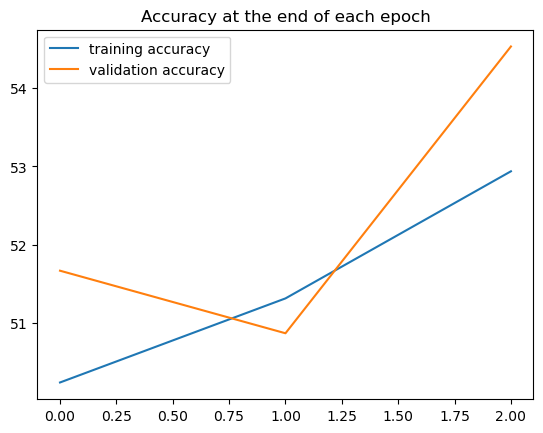

In [9]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [10]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(1550), tensor(1526), tensor(1636)]
Test accuracy: 54.533%
